# Exercise 8 Blob detection for SIFT discription

These exercises will introduce you to blobs and SIFT features. In this exercise you will write the \
code for the blob detector as well as use the SIFT feature detector and matcher.

**Blob detector**
You will implement a blob detector using the Difference-of-Gaussian (DoG) method and apply it \
to the sample image of sunflowers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

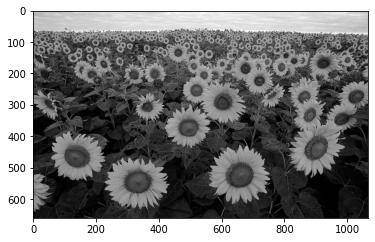

In [2]:
# Load image
img = cv2.imread('sunflowers.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")

#### 8.1 Scaling

Create the function ```im_scales = scaleSpaced(im, sigma, n)```, where im_scales is a scale pyramid of the original image im.  \
The width and height of all images in the pyramid im_scales are exactly the same as the original image im. In other words \
im_scales is *not a pyramid in image sizes; only in scale space*. 


This function should apply a Gaussian kernel of width $\sigma 2^i$, \
(where i = 0, 1, . . . , n − 1.)

**NB** This is providing the gaussians that we will then use to create DoG images used in blob detection!

In [36]:
def scaleSpaced(im, sigma, n):
    im_scales = []
    for i in range(n):
        k_size = math.ceil(sigma*(2**i))
        if k_size % 2 == 0:
            k_size+=1
        blur = cv2.GaussianBlur(im, ksize=(k_size,k_size),
                                sigmaX=0, #k_size
                                ) # sigmaX=0 makes it scale with the kernel size.
        im_scales.append(blur.copy())
    return im_scales

**NB** But only increase kernel size? If kernel size = 2*sigma, then we have already got like 97% blurr, what more can we get??

In [123]:
im_scales = scaleSpaced(gray, 11, 8)

C:\Users\henri\AppData\Local\Temp\ipykernel_16080\1111775689.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


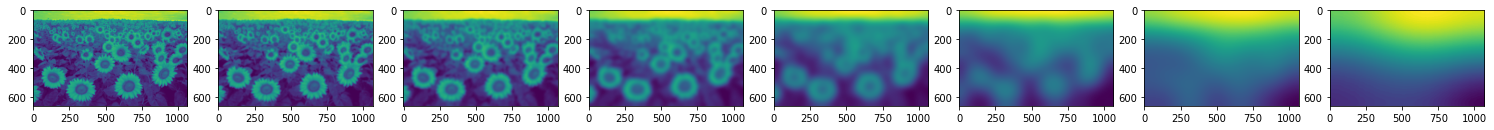

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(26,6))
ax[0].imshow(im_scales[0]), ax[1].imshow(im_scales[1]), ax[2].imshow(im_scales[2]), ax[3].imshow(im_scales[3]), ax[4].imshow(im_scales[4]), ax[5].imshow(im_scales[5]), ax[6].imshow(im_scales[6]), ax[7].imshow(im_scales[7])
fig.show()

In [164]:
print(np.sum(im_scales[5]) > np.sum(im_scales[6]))
im_scales[0], im_scales[1]

True


(array([[187, 187, 187, ..., 191, 191, 191],
        [187, 187, 187, ..., 191, 191, 191],
        [188, 188, 188, ..., 190, 190, 190],
        ...,
        [ 16,  15,  14, ...,  12,  12,  12],
        [ 16,  15,  14, ...,  12,  12,  12],
        [ 16,  15,  14, ...,  12,  12,  12]], dtype=uint8),
 array([[188, 188, 188, ..., 190, 190, 190],
        [188, 188, 188, ..., 191, 190, 190],
        [188, 188, 188, ..., 191, 191, 191],
        ...,
        [ 14,  14,  14, ...,  12,  12,  12],
        [ 14,  14,  14, ...,  12,  12,  12],
        [ 14,  14,  14, ...,  12,  12,  12]], dtype=uint8))

#### 8.2 DoG - Difference of gaussians

Now, create the function ```DoG = differenceOfGaussian(im, sigma, n)```, where DoG is the scale \
space DoGs of the original image im. Like the scaleSpaced function, the returned images are all \
the same size as the original.


In [192]:
def differenceOfGaussian(im, sigma, n):
    im_scales = scaleSpaced(im=im, sigma=sigma, n=n)
    DoG = []
    for i in range(1, len(im_scales)):
        # Uint8 would wrap around with negative no. Change to int 32
        diff = np.subtract(np.int32(im_scales[i]), np.int32(im_scales[i-1]))
        DoG.append(diff)
    return DoG

In [196]:
DoG = differenceOfGaussian(gray, 11, 8)

C:\Users\henri\AppData\Local\Temp\ipykernel_16080\41749049.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


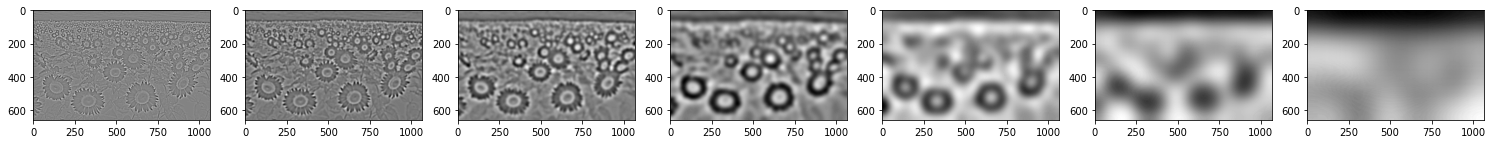

In [197]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(26,6))
ax[0].imshow(DoG[0],cmap="gray"), ax[1].imshow(DoG[1],cmap="gray"), ax[2].imshow(DoG[2],cmap="gray"), ax[3].imshow(DoG[3],cmap="gray"), ax[4].imshow(DoG[4],cmap="gray"), ax[5].imshow(DoG[5],cmap="gray"), ax[6].imshow(DoG[6],cmap="gray")
fig.show()

#### 8.3 Blob detection

Finally, create the function ```blobs = detectBlobs(im, sigma, n, threshold)```, where blobs are \
the blobs (pixels) of the original image im with a DoG larger than a threshold. You should also \
implement non-maximum suppression to increase the robustness of the detector. \
Try the detector on the image of sunflowers. Visualize your result by drawing a circle for each \
image, with the radius proportional to the scale of the blob. You can use cv2.circle for this.

In [9]:
from scipy import ndimage

In [10]:
def non_maximum_suppression(data, order=1):
    """Detects local maxima in a 3D array

    params:
        : data : 3d ndarray
        : order : int
            How many points on each side to use for the comparison
    return:
        : coords : ndarray
            coordinates of the local maxima
        : values : ndarray
            values of the local maxima
    """
    size = 1 + 2 * order
    footprint = np.ones((size, size, size))
    footprint[order, order, order] = 0

    filtered = ndimage.maximum_filter(data, footprint=footprint)
    mask_local_maxima = data > filtered
    data[~mask_local_maxima] = 0
    
    return data

In [214]:
def detectBlobs(im, sigma, n, threshold, verbose=False):
    # 1 Get all DoGs 
    DoG = differenceOfGaussian(im=im,sigma=sigma, n=n)
    if verbose:
        stack = [DoG[i] for i in range(len(DoG))]
        print("Total sum before thresholding",
         np.sum(np.array(stack)), end=" \t")
        print("max:", np.max(stack), end=" \t")
        print("mean:", np.mean(stack))
        print("------------------------")
    # 2 Threshold the blobbyness
    for i in range(len(DoG)):
        DoG[i] *= np.int32(DoG[i] > threshold)
    # 3 Stack them all
    stack = np.array([DoG[i] for i in range(len(DoG))])
    if verbose:
        print("Total sum after thresholding", np.sum(stack), end=" \t")
        print("max:", np.max(stack), end=" \t")
        print("mean:", np.mean(stack))
        print("------------------------")

    # 4 Non max supression in 3D
    stack = non_maximum_suppression(stack)
    if verbose:
        print("Total sum after non-max-supression", np.sum(stack), end=" \t")
        print("max:", np.max(stack), end=" \t")
        print("mean:", np.mean(stack))
        print("------------------------")
    # 5 Get non-zero location
    xs, ys = [], []
    for i in range(len(DoG)):
        x, y = np.where(stack[i]>0)
        xs += list(x)
        ys += list(y)
    return (np.array(list(xs)), np.array(list(ys)))

In [218]:
blobs = detectBlobs(im=gray, sigma=11, n=8, threshold=20, verbose=True)
(len(blobs[0]), len(blobs[1]))

Total sum before thresholding -24683 	max: 47 	mean: -0.005011858060638548
------------------------
Total sum after thresholding 2453854 	max: 47 	mean: 0.4982525604476824
------------------------
Total sum after non-max-supression 5558 	max: 43 	mean: 0.00112854625049747
------------------------


(235, 235)

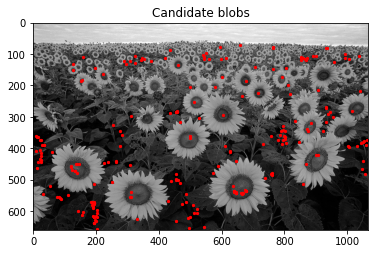

In [219]:
plt.scatter(blobs[1], blobs[0], s=5, c="red")
plt.gca().invert_yaxis()
plt.title("Candidate blobs")
plt.imshow(gray, cmap="gray")